# Introduction

This Jupyter notebook contains the `python` and `R` code for running the analysis in:

    Ahern, Christopher and Robin Clark. Conflict, Cheap Talk, and Jespersen's Cycle. 2016.

Here is system and version information. Using the `Anaconda` python distribution is highly recommended for installing and configuring the `SciPy` stack and other dependencies.

In [1]:
import IPython
import sys
import numpy as np
import scipy
print 'Python version: ', sys.version
print 'Platform: ', sys.platform
print
print 'IPython version: ', IPython.__version__
print 'NumPy version: ', np.__version__
print 'SciPy version: ', scipy.__version__

Python version:  2.7.12 |Anaconda 2.4.0 (x86_64)| (default, Jun 29 2016, 11:09:23) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
Platform:  darwin

IPython version:  4.0.0
NumPy version:  1.10.4
SciPy version:  0.17.0


Below we add add additional commentary and code about different aspects of the paper and the model proposed for the functional Jespersen cycle. The sections below can be grouped into three general categories.

* **Model components**: here we discuss some of the model components in more detail and provide code for visualizations
* **Equilibria calculation**: here calculate the evolutionarily stable strategies of the signaling game defined in the document
* **Dynamics**: here we outline choices made in using the data, define the replicator dynamics in more detail, and fit the dynamic model to data

# 1. Model components

In this section we focus on the prior probability distribution over states and visualize the utility functions used in the game.

## Prior probability

We use *beta distributions* as a prior probability over states $T : [0,1]$, in the signaling game. The distribution is often written $\mathcal{B}(\alpha, \beta)$ and is controlled by two shape parameters $\alpha$ and $\beta$. Below we plot the prior where $\alpha=1$ and $\beta$ is free to vary.

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline
hfont = {'fontname':'Times New Roman'}

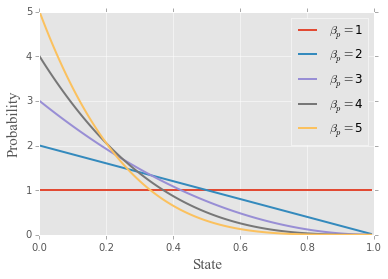

In [3]:
x = np.arange (0, 1, 0.01)

plt.style.use('ggplot')
for beta_var in range(1,6):
        y = beta.pdf(x,1,beta_var)
        plt.plot(x,y, label=r'$\beta_p = $' + str(beta_var), linewidth=2)
plt.legend(loc='upper right')
plt.ylabel("Probability", fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.savefig('../local/out/beta-distribution.pdf', format='pdf', dpi=1000)
plt.show()

For the dynamic model we consider a discretized version of the state space in order to keep fitting the model tractable. We use a *beta-binomial* over the states $T : \{t_0, ..., t_n \}$ and actions $A : \{a_0, ..., a_n \}$, where $t_i = a_i = \frac{i}{n}$. In this case, we use one hundred states and actions, $n=100$ to approximate the beta distribution.

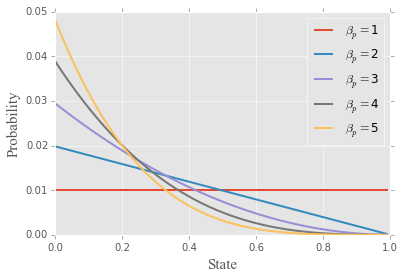

In [4]:
from scipy.special import beta as beta_func
from scipy.misc import comb
def beta_binomial(n, alpha, beta):
    return np.array([comb(n - 1, k) * beta_func(k + alpha, n - 1 - k + beta) / beta_func(alpha, beta) for k in range(n)])

plt.style.use('ggplot')
for beta_var in range(1,6):
        y = beta_binomial(len(x), 1, beta_var)
        plt.plot(x, y, label=r'$\beta_p = $' + str(beta_var), linewidth=2)
plt.legend(loc='upper right')
plt.ylabel("Probability", fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.show()

The only thing that changes when using the beta-binomial distribution is the scale of the y-axis because the beta-binomial is a probability mass function whereas the beta distribution is a probability density function. Note that the probability for any discrete state $t_i$ is approximately the value of the beta distribution at that point scaled by the number of discrete states.

\begin{equation}
    p(t_i) \approx \frac{\mathcal{B}(\alpha, \beta)(t_i)}{n}
\end{equation}

## Utility functions

In the signaling game model we use a modified version of the payoffs defined in Crawford and Sobel (1982). The main motivation for taking these as a starting point is that it offers a means of modeling signaling where the state and action spaces are continuous.  This is exactly what we want if we assume that standards of evidence and actions taken in response to them are continuous. More importantly, these utilities allow us to represent a preference for proximity between the standard of precision and the action taken.


Now, as a point of reference, the utilities used in Crawford and Sobel (1982) are the following.

\begin{equation}
\begin{split}
	U_S(s, r) &= -(a - t - b)^2\\
	U_R(s, r) &= -(a - t)^2
\end{split}
\end{equation}

We can visualize these using the following code.

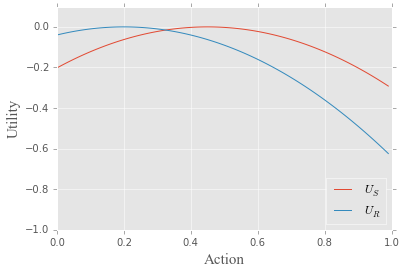

In [5]:
x = np.arange (0, 1, 0.01)
# The actual standard of evidence
t = .2
# The degree of speaker bias
b = .25
U_S = [-(a - t - b)**2 for a in x]
U_R = [-(a - t)**2 for a in x]
plt.plot(x, U_S, label=r'$U_S$')
plt.plot(x, U_R, label=r'$U_R$')
plt.ylim(-1.0, .1)
plt.legend(loc='lower right')
plt.ylabel('Utility', fontsize=15, **hfont)
plt.xlabel("Action", fontsize=15, **hfont)
plt.show()

We modify these utility functions in two ways. First, we add a constant value so that the utilities are always positive and always fall in the unit interval. Second, we constrain speakers to only prefer actions that hearers can actually take. That is, speakers cannot prefer an action $a > 1$ for any value of $t$ and $b$.

\begin{equation}
\begin{split}
	U_S(s, r) &= 1 - (a - t - (1-t)b)^2\\
	U_R(s, r) &= 1 - (a - t)^2
\end{split}
\end{equation}

We can visualize these using the code below. Note that for these values, the sets of utility functions are slightly but not dramatically different.

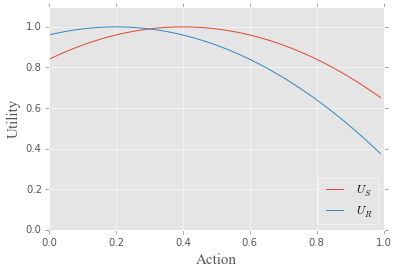

In [6]:
x = np.arange (0, 1, 0.01)
# The actual standard of evidence
t = .2
# The degree of speaker bias
b = .25
U_S = [1 - (a - t - (1-t)*b)**2 for a in x]
U_R = [1 - (a - t)**2 for a in x]
plt.plot(x, U_S, label=r'$U_S$')
plt.plot(x, U_R, label=r'$U_R$')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.ylabel('Utility', fontsize=15, **hfont)
plt.xlabel("Action", fontsize=15, **hfont)
plt.show()

Now, there is nothing crucial about  the linear relationship between speaker state and the speaker's preferred action on the part of the hearer the linear relationship between $t$ and $b$. In fact, the relationship is also linear in the original formulation provided by Crawford and Sobel (1982): it has the same intercept, but a different slope. All that we have done is to constrain the values for those preferences so that speakers can't prefer non-available actions on the part of hearers. Note that we could just as well pick any arbitrary function such that $t < f(t) < 1$. Intuitively, in the unit square, draw a line continuously right that never goes below the diagonal and ends in the upper right. Any such function will do. Now, the function we have chosen stems from constraining speaker preferences to possible actions, but it also offers a convenient functional form for working with.

We could just as well define any function that models speakers preferring higher actions than the given state, while also being constrained to actions that exist. For example, consider the functions below.

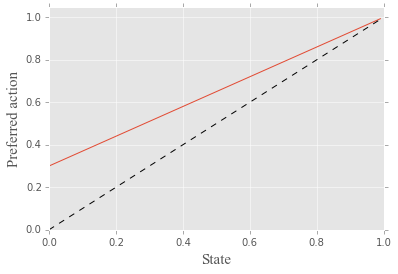

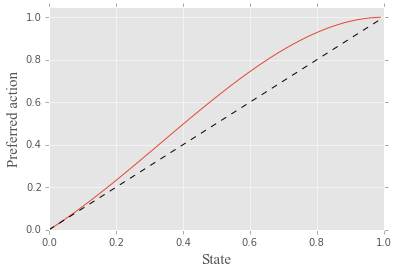

In [7]:
x = np.arange (0, 1, 0.01)
b = .3
plt.plot(x, x + (1-x)*b)
plt.ylim(0, 1.05)
plt.plot(x, x, 'k--')
plt.ylabel('Preferred action', fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.show()
x = np.arange (0, 1, 0.01)
b = .3
y = -x**3 + x**2 + x
plt.plot(x, y)
plt.ylim(0, 1.05)
plt.plot(x, x, 'k--')
plt.ylabel('Preferred action', fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.show()

# 2. Evolutionarily stable strategies of the signaling game

Calculating the evolutionarily stables strategies of the signaling game requires defining the expected utilities of speakers and hearers, taking partial derivatives, and finding the values that maximize the expected utilities. Note that this analysis is done using the continuous state space, whereas for the dynamic model we assume a discretized version of the state space.

First, we import `sympy`, which is a library for symbolic math in `python`.

In [8]:
from sympy import *
from sympy.stats import Beta, density

Next, we define the symbols that we'll use in constructing the utility functions and the prior probability.

In [9]:
t, t_0, m_0, m_1, a_0, a_1, b = symbols('t t_0 m_0 m_1 a_0 a_1 b')
T = Beta("t", 1, 2)

Then, we build the actual utility functions and the respective expected utilities. Note that we can save a bit of effort by noting that the speaker's utility is defined by the hearer's response and the hearer's utility is the speaker's where $b=0$.

In [10]:
Utility_S_0 = 1 - (a_0 - t - (1-t)*b)**2
Utility_S_1 = 1 - (a_1 - t - (1-t)*b)**2
E_Utility_S = integrate(Utility_S_0*density(T)(t).evalf(), (t, 0, t_0)) + \
                integrate(Utility_S_1*density(T)(t).evalf(), (t, t_0, 1))
E_Utility_R = E_Utility_S.subs(b, 0)

Now, we can differentiate the utility functions by the actions available to speakers and hearers, and solve for the values of $t_0, a_0, a_1$ that maximize the expected utilities.

In [11]:
t0_sol = Eq(solve(diff(E_Utility_S, t_0), t_0)[0], t_0)
a0_sol = Eq(solve(diff(E_Utility_R, a_0), a_0)[0], a_0)
a1_sol = Eq(solve(diff(E_Utility_R, a_1), a_1)[0], a_1)

This can take a bit of time, so by default we've supplied the set of solutions to this system of equations. Note that there are two solutions because we haven't supplied the information to the solver that the values are constrained to be positive. In fact, we are only interested in the second solution that yields an ESS.

    ESS = solve([t0_sol, a0_sol, a1_sol], [t_0, a_0, a_1])

In [12]:
ESS = [((9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0), 0.333333333333333*(-3.0 + 2.0*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/((-2.0 + (9.0*b - (9.0*b**2 - 18.0*b + 5.0)**0.5 - 3.0)/(6.0*b - 2.0))*(6.0*b - 2.0)), 0.333333333333333 + 0.666666666666667*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0)), ((9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0), 0.333333333333333*(-3.0 + 2.0*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/((-2.0 + (9.0*b + (9.0*b**2 - 18.0*b + 5.0)**0.5 - 3.0)/(6.0*b - 2.0))*(6.0*b - 2.0)), 0.333333333333333 + 0.666666666666667*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))]
ESS = ESS[1]

We can visualize this result in the following manner. First, we note that speakers only use a single message if bias is sufficiently large.

In [13]:
b_critical = solve(ESS[1], b)[0]
b_critical

0.166666666666667

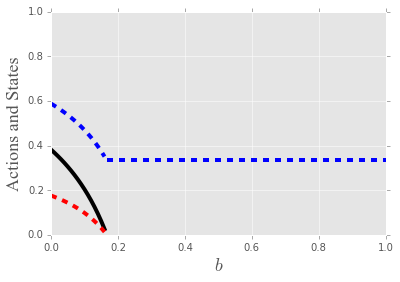

In [14]:
x = np.arange (0, b_critical, 0.01)
plt.style.use('ggplot')
plt.plot(x, [ESS[0].subs(b, value) for value in x], 'k', linewidth=4)
plt.plot(x, [ESS[1].subs(b, value) for value in x], 'r', linewidth=4, linestyle='--')
plt.plot(x, [ESS[2].subs(b, value) for value in x], 'b', linewidth=4, linestyle='--')
plt.axhline(1/3.0, b_critical, 1, color='b', linewidth=4, ls='--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel(r"$b$", fontsize=18, **hfont)
plt.ylabel(r"Actions and States", fontsize=18, **hfont)
plt.savefig("../local/out/ESS-beta.pdf", format='pdf', dpi=1000, fontsize=18)
plt.show()

We can find the values of the variables for a given value of $b$. For example, for $b=0$, we can do the following.

In [15]:
[item.subs(b, 0).evalf() for item in ESS]

[0.381966011250105, 0.175954681666807, 0.587977340833403]

# 3. Dynamics

# Visualizing and formatting the data

We load the data into $R$, plot the data and output in a format that can be used to fit data to the functional cycle.

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
library(ggplot2, warn.conflicts=F, quietly=T)
library(dplyr, warn.conflicts=F, quietly=T)
library(extrafont)
library(reshape2, quietly=T)
neg.data.full = read.csv("../data/neg-data.csv", header=T)
neg.data.full = tbl_df(neg.data.full)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Use suppressPackageStartupMessages() to eliminate package startup
messages.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Registering fonts with R

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Here we filter out texts that are known to be outliers and exclude everything but sentential negation in declaratives.

In [18]:
%%R
# Filter out tokens without do-support label, year, or type
excluded.texts = c("CMORM","CMBOETH","CMNTEST","CMOTEST")
# CMBOETH : translation of Boethius' "Consolation of Philosophy", which is notably stilted
# CMORM   : Ormulum is very specific poetic format where adding an additional syllable for the meter is required
# CMOTEST, CMNTEST : Old and new testaments, which are known to carry archaisms longer than other texts
neg.data = neg.data.full %>% 
            filter(finite != "-") %>% # Exclude non-finite clauses
            filter(clausetype != "imperative") %>% # Exclude imperatives
            filter(exclude != "only") %>% # Exclude focus constructions
            filter(exclude != "constituent") %>% # Exclude constituent negation
            filter(exclude != "contraction") %>% # Exclude contraction
            filter(exclude != "coordination") %>% # Exclude coordinated clauses
            filter(exclude != "concord") %>% # Exclude cases of negative concord
            filter(exclude != "X") %>% # Exclude corpus errors
            filter(! author %in% excluded.texts) %>% # Exclude texts
            mutate(stages = ifelse(has.both, 2, ifelse(has.ne, 1, 3))) %>%
            select(year, author, stages)

We plot the data for all three variants over the course of Middle English.

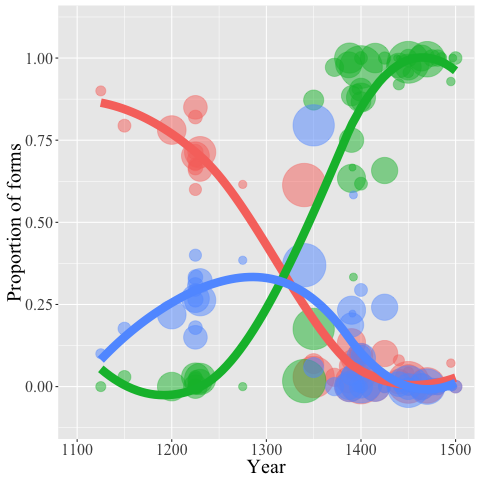

In [19]:
%%R
neg.plot.data =  neg.data %>% group_by(year, author) %>% 
    summarize(total=n(), ne=sum(stages==1, na.rm=TRUE)/total,
              not=sum(stages==3, na.rm=TRUE)/total,
              ne.not=sum(stages==2, na.rm=TRUE)/total)
neg.plot.data = melt(neg.plot.data, id=c("year", 'author', "total"))

p = ggplot(neg.plot.data, aes(x = year, y = value, color = variable)) +
  geom_point(aes(size = total), alpha = 0.5) +
  geom_smooth(method="loess", se = F, size=4) + # aes(weight = total), span=.6,
  scale_x_continuous(name="Year", limits=c(1100, 1500)) +
  scale_y_continuous(name="Proportion of forms", breaks=seq(0,1,.25)) +   scale_size_area("N", max_size = 20) +
  theme(text = element_text(size=20, family="Times New Roman"), legend.position="none") +  
  coord_cartesian(ylim = c(-.1,1.1)) #+ theme_hc()
print(p)
ggsave('../local/out/neg-plot.pdf', height=6, width=8)

We also plot the data treating post-verbal tokens *as if* they were bipartite tokens in order to model the functional cycle.

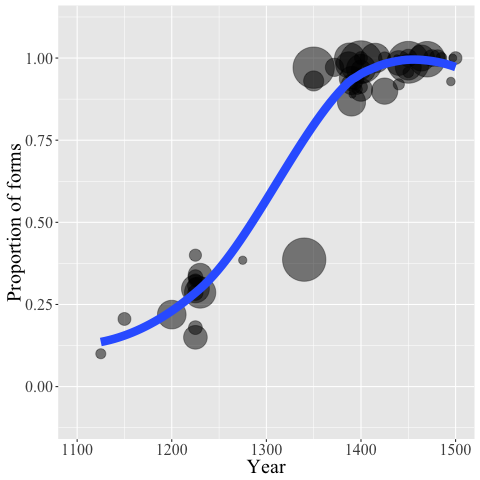

In [20]:
%%R
# Compare ne to ne...not and not
first.data = neg.data %>% group_by(year) %>% mutate(value = as.integer(! stages==1)) %>% select(year, author, value)
first.plot.data = first.data %>% group_by(year, author) %>% 
    summarize(p = sum(value)/n(), total=n())
p = ggplot(aes(x = year, y = p), data = first.plot.data) +
  geom_point(aes(size = total), alpha = 0.5, position = "identity") +
  geom_smooth(method="loess", se = F, size=4) + 
  scale_x_continuous(name="Year", limits=c(1100, 1500)) +   
  scale_y_continuous(name="Proportion of forms", breaks=seq(0,1,.25)) +
  theme(text = element_text(size=20, family="Times New Roman")) + theme(legend.position="none") +
  scale_size_area("N", max_size = 20) +  coord_cartesian(xlim = c(1090,1540)) + coord_cartesian(ylim = c(-.1,1.1))
print(p)
ggsave('../local/out/func-plot.pdf', height=6, width=8)

Note that if we were to compare only $ne$ and $ne...not$, excluding $not$ entirely from our analysis, we would run the risk of attributing too much to noisy fluctuations after 1350 when $ne$ and $ne...not$ combined cease to be the majority of forms. Indeed, after 1350 $ne$ becomes more frequent than $ne...not$ again.

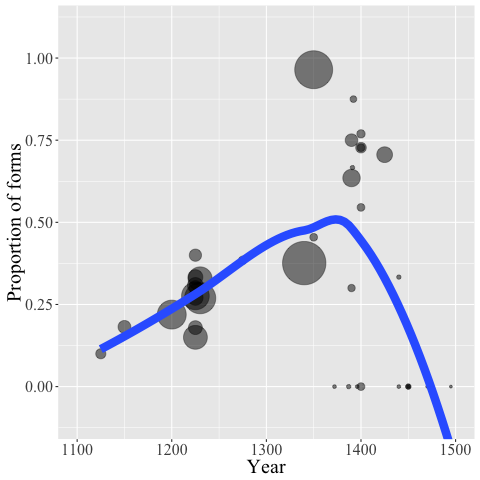

In [21]:
%%R
# Compare ne to ne...not and not
exclude.data = neg.data %>% filter(! stages == 3) %>% group_by(year) %>% mutate(value = as.integer(! stages==1)) %>% select(year, author, value)
exclude.plot.data = exclude.data %>% group_by(year, author) %>% 
    summarize(p = sum(value)/n(), total=n())
p = ggplot(aes(x = year, y = p), data = exclude.plot.data) +
  geom_point(aes(size = total), alpha = 0.5, position = "identity") +
  geom_smooth(method="loess", se = F, size=4) + 
  scale_x_continuous(name="Year", limits=c(1100, 1500)) +   
  scale_y_continuous(name="Proportion of forms", breaks=seq(0,1,.25)) +
  theme(text = element_text(size=20, family="Times New Roman")) + theme(legend.position="none") +
  scale_size_area("N", max_size = 20) +  coord_cartesian(xlim = c(1090,1540)) + coord_cartesian(ylim = c(-.1,1.1))
print(p)

Finally, we output the data in a format that will make it easy to calculate a loss function in a vectorized format.

In [22]:
%%R
functional.cycle.data = data.frame(year=rep(0, 401), has.tokens=rep(0,401), ones=rep(0, 401), zeros=rep(0, 401))
for (i in c(0:401)) {
    functional.cycle.data$year[i] = i + 1100 - 1
    functional.cycle.data$has.tokens[i] = nrow(first.data %>% filter(year == i + 1100 - 1)) > 0
    functional.cycle.data$ones[i] = nrow(first.data %>% filter(year == i + 1100 - 1, value == 1))
    functional.cycle.data$zeros[i] = nrow(first.data %>% filter(year == i + 1100 - 1, value == 0))
}
write.csv(functional.cycle.data, "../data/functional-cycle-data.csv", row.names=F)

# Defining the evolutionary game dynamics

Next, we define the discrete-time version of the behavioral replicator dynamics outlined in Huttegger and Hofbauer (2015). The basic intuition is that we treat each state and each message *as if* it were its own population. This reduces calculating the dynamics to matrix multiplication.

First, we define the payoff matrices for senders and receivers, which depend solely on the utility functions of senders and receivers respectively.

$\textbf{A}$ is an $n \times n$ matrix such that $\textbf{A}_{ij} = U_S(t_i, a_j)$:

\begin{equation}
\textbf{A} =
 \begin{pmatrix}
  U_S(t_1, a_1) & \cdots & U_S(t_1, a_j) & \cdots & U_S(t_1, a_n) \\
  \vdots	        & \ddots & \vdots           &           & \vdots \\
  U_S(t_i, a_1) & \cdots & U_S(t_i, a_j) & \cdots & U_S(t_i, a_n) \\  
  \vdots	        &  & \vdots           &   \ddots        & \vdots \\
  U_S(t_n, a_1) & \cdots & U_S(t_n, a_j)  & \cdots & U_S(t_n, a_n) \\
 \end{pmatrix}
\end{equation}

 
$\textbf{B}$ is an $n \times n$ matrix such that $\textbf{B}_{ij} = U_R(t_i, a_j)$:

\begin{equation}
\textbf{B} =
 \begin{pmatrix}
  U_R(t_1, a_1) & \cdots & U_R(t_1, a_j) & \cdots & U_R(t_1, a_n) \\
  \vdots	        & \ddots & \vdots           &           & \vdots \\
  U_R(t_i, a_1) & \cdots & U_R(t_i, a_j) & \cdots & U_R(t_i, a_n) \\  
  \vdots	        &  & \vdots           &   \ddots        & \vdots \\
  U_R(t_n, a_1) & \cdots & U_R(t_n, a_j)  & \cdots & U_R(t_n, a_n) \\
 \end{pmatrix}
\end{equation}

Second, we define the speaker and hearer populations.

$\textbf{X}$ is a stochastic population matrix such that the proportion of the population in $x_i$ using $m_j$ is $x_{ij}$, with $\sum_j x_{ij} = 1$.

\begin{equation}
\textbf{X} =
 \begin{pmatrix}
  x_{11} &  x_{12} & x_{13} \\
  \vdots        & \vdots & \vdots \\
  x_{i1} &  x_{i2} & x_{i3} \\
  \vdots	& \vdots    & \vdots \\
  x_{n1} &  x_{n2} & x_{n3} \\
 \end{pmatrix}
\end{equation}
 
Intuitively, each row corresponds to a given state. Each element in the row corresponds to the proportion of use in that population.  Each row sums to one because the proportion using the various  signals must sum to one.
 
$\textbf{Y}$ is a population matrix such that the proportion of the population in $y_i$ responding with action $a_j$ is $y_{ij}$, with $\sum_j y_{ij} = 1$.

\begin{equation}
\textbf{Y} =
 \begin{pmatrix}
  y_{11} & \cdots & y_{1j}  & \cdots & y_{1n} \\
  y_{21} & \cdots & y_{2j}  & \cdots & y_{2n} \\
  y_{31} & \cdots & y_{3j}  & \cdots & y_{3n} \\
 \end{pmatrix}
\end{equation}
 
 Again, intuitively, each row corresponds to a given message. Each element in the row corresponds to the proportion of different responses to the message. Each row sums to one because the proportion using the various responses must sum to one.

$\textbf{P}$ is a stochastic matrix such that $\forall i \textbf{P}_i = P(t_1),...,P(t_n)$. That is, $\textbf{P}$ is just $n$ rows of the prior probability distribution over states.

\begin{equation}
\textbf{P} =
 \begin{pmatrix}
  P(t_1) & \cdots & P(t_i)  & \cdots & P(t_n) \\
  \vdots &  & \vdots  & & \vdots  \\
  P(t_1) & \cdots & P(t_i)  & \cdots & P(t_n) \\
 \end{pmatrix}
\end{equation}

With slight abuse of notation, the expected utility of sending message $m_j$ in state $t_i$, where $\textbf{Y}^T$ is the transpose of $\textbf{Y}$:

\begin{equation}
	E [ U_S(\textbf{X}_{ij}, \textbf{Y}) ] = (\textbf{A}\textbf{Y}^T)_{ij}
\end{equation}

The average expected utility in a speaker population $x_i$:

\begin{equation}
	E [ U_S(\textbf{X}_{i}, \textbf{Y}) ] = \sum_j \mathbf{X}_{ij} E[U_S(\mathbf{X}_{ij}, \mathbf{Y})] = (\textbf{X}(\textbf{A}\textbf{Y}^T)^T)_{ii}
\end{equation}

Let $\mathbf{\hat{X}}$ be the speaker expected utility matrix normalized by the average expected utilities such that:

\begin{equation}
    \mathbf{\hat{X}}_{ij} = \frac{(\textbf{A}\textbf{Y}^T)_{ij}}{(\textbf{X}(\textbf{A}\textbf{Y}^T)^T)_{ii}}
\end{equation}

For both populations, under the discrete-time replicator dynamics strategies grow in proportion to the amount by which they exceed the average payoff in the population. The discrete-time replicator dynamic for message $m_j$ in state $t_i$:

\begin{equation}
     \textbf{X}_{ij}' = \textbf{X}_{ij}\frac{E[U_S(\textbf{X}_{ij}, Y)]}{E[U_S(\mathbf{X}_{i}, \textbf{Y})]}
\end{equation}

The speaker population at the next point in time is then given by the following, where $\otimes$ indicates the element-wise Hadamard product:

\begin{equation}
    \mathbf{X}' = \mathbf{X} \otimes \mathbf{\hat{X}}
\end{equation}

Now that we have defined the discrete-time replicator dynamics for the speaker population, we can do the same for the hearer population with a few additions. Let $\textbf{C}$ be the conditional probability of a state given a message. That is, $\textbf{C}_{ij} = P(t_i | m_j)$, where $\otimes$ indicates element-wise Hadamard multiplication and $\oslash$ indicates the element-wise Hadamard division.

\begin{equation}
\textbf{C} = (P^T \otimes X) \oslash (PX)
\end{equation}

The expected utility of hearer responding to message $m_i$ with action $a_j$:
 
\begin{equation}
	E [ U_R(\textbf{X}, \textbf{Y}_{ij}) ] = (\textbf{B}^T\textbf{C})_{ji}
\end{equation}

Since the resulting matrix is $n \times m$, we swap the indices to get the appropriate value. Each column corresponds to a hearer population, and each row corresponds to a response action.

The average expected utility in a hearer population $y_i$:

\begin{equation}
	E [ U_R(\textbf{X}, \textbf{Y}_{i}) ] = \sum_j \mathbf{Y}_{ij} E[U_R(\mathbf{X}, \mathbf{Y}_{ij})] = (\textbf{Y}(\textbf{B}^T\textbf{C})_{ji})_{ii}
\end{equation}

Let $\mathbf{\hat{Y}}$ be the population normalized matrix for hearer expected utilities such that:

\begin{equation}
    \mathbf{\hat{Y}}_{ji} = \frac{(\textbf{B}^T\textbf{C})_{ji}}{(\textbf{Y}(\textbf{B}^T\textbf{C})_{ji})_{ii}}
\end{equation}

The discrete-time replicator dynamic for action $a_j$ in response to message $m_i$:

\begin{equation}
     \textbf{Y}_{ij}' = \textbf{Y}_{ij}\frac{E [ U_R(\textbf{X}, \textbf{Y}_{ij}) ]}{E [ U_R(\textbf{X}, \textbf{Y}_{i})] }
\end{equation}

The hearer population at the next point in time is then given by the following:

\begin{equation}
    \mathbf{Y}' = \mathbf{Y} \otimes \mathbf{\hat{Y}}^T
\end{equation}


In [23]:
def discrete_time_replicator_dynamics(n_steps, X, Y, A, B, P):
    """Simulate the discrete-time replicator dynamics.

    Parameters
    ----------
    n_steps : int, the number of discrete time steps to simulate
    X : stochastic sender matrix
    Y : stochastic receiver matrix
    A : sender utility matrix
    B : receiver utility matrix
    P : prior probability over states matrix

    Returns
    ----------
    X_t : array-like, the state of the sender population at each year
    Y_t : array-like, the state of the receiver population at each year
    """
    # Get the number of states
    X_nrow = X.shape[0]
    # Get the number of messages
    X_ncol = X.shape[1]
    # Get the number of actions
    Y_nrow = Y.shape[0]
    Y_ncol = Y.shape[1]
    # Create empty arrays to hold flattened matrices for the population over time
    X_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    Y_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    # Set the initial state
    X_t[0,:] = X.ravel()
    Y_t[0,:] = Y.ravel()
    # Iterate forward over (n-1) steps
    for i in range(1,n_steps):
        # Get the previous state
        X_prev = X_t[i-1,:].reshape(X_nrow, X_ncol)
        Y_prev = Y_t[i-1,:].reshape(Y_nrow, Y_ncol)
        # Calculate the scaling factors
        E_X = A * Y_prev.T
        X_bar = (((A * Y_prev.T) * X_prev.T).diagonal()).T
        X_hat = E_X / X_bar
        # Calculate probability of states given messages
        C = np.divide(np.multiply(P.T, X_prev), (P * X_prev)[0])
        E_Y = (B.T * C).T
        Y_bar = ((E_Y*Y_prev.T).diagonal()).T
        Y_hat = np.divide(E_Y, Y_bar)
        # Calculate current states
        X_t[i,:] = np.multiply(X_prev, X_hat).ravel()
        Y_t[i,:] = np.multiply(Y_prev, Y_hat).ravel()
    return X_t, Y_t

Now that we have defined the dynamics, we define several functions to construct the model, including one that takes the parameters of the model and constructs the initial state.

In [24]:
# Define various components used to construct the model
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy.optimize import fmin
from scipy.special import beta as beta_func
from scipy.special import binom
from scipy.misc import comb
from scipy.stats import chi2
from functools import partial

import matplotlib.pyplot as plt
plt.style.use('ggplot')
hfont = {'fontname':'Times New Roman'}


def beta_binomial(alpha, beta, n=100):
    return np.matrix([comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta) for k in range(n)])

def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
def U_R(state, action):
    return 1 - (action - state)**2

def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

def sender_matrix(b, number=100):
    return np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
def receiver_matrix(number=100):
    return np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])


def construct_initial_state(a_s, b_p, b=0):
    """Construct the initial state of the model.

    Parameters
    ----------
    a_s, b_p, b : parameters defined in document

    Returns
    ----------
    X0 : array-like, the initial state of the speaker population
    Y0 : array-like, the initial state of the hearer population
    prior : prior probability over states
    """
    # Define prior probability
    a_p = 1
    prior = beta_binomial(a_p, b_p)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A = sender_matrix(b)
    B = receiver_matrix(    )
    # Define speaker population
    X0_m2 = beta_binomial(a_s, 1)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Calculate probability of state given m2
    p_ti_m2 = np.multiply(X0[:,1], prior.T)
    p_m2 = prior * X0[:,1]
    p_t_m2 = p_ti_m2 / p_m2
    # Calculate probability of state given m1
    p_ti_m1 = np.multiply(X0[:,0], prior.T)
    p_m1 = prior * X0[:,0]
    p_t_m1 = p_ti_m1 / p_m1
    # Calculate expected utility for receiver of action given m1
    E_ai_m1 = p_t_m1.T * B
    E_a_m1 = E_ai_m1 / E_ai_m1.sum()
    # Calculate expected utility for receiver of action given m2
    E_ai_m2 = p_t_m2.T * B
    E_a_m2 = E_ai_m2 / E_ai_m2.sum()
    # Define hearer population
    Y0 = np.vstack([E_a_m1, E_a_m2])

    return X0, Y0, A, B, prior

Now we define a function that takes a set of parameters that define a starting state and simulates the dynamics for a specified amount of time.

In [25]:
def simulate_dynamics(params, n_years=401, time_scale=1, number=100):
    """Simulate the discrete-time behavioral replicator dynamics for the game.

    Parameters
    ----------
    n_years : int, the number of discrete time steps to simulate
    time_scale : int (optional), the number of discrete time steps per year
    number : int, (optional), the number of discretized states and actions
    params : array-like, parameters that determine starting state of population

    Returns
    ----------
    X_sol : array-like, the state of the speaker population at each year
    Y_sol : array-like, the state of the hearer population at each year
    prior : prior probability over states
    """
    # Unpack the parameters
    a_s, b_p, b = params
    # Construct the initial state
    X0, Y0, A, B, prior = construct_initial_state(a_s, b_p, b)
    # Create prior probability matrix
    P = np.repeat(prior, 2, axis=0)
    # Iterate using dynamics to get values for the number of years
    X_sol, Y_sol = discrete_time_replicator_dynamics(n_years*time_scale, X0, Y0, A, B, P)
    X_sol = X_sol[0::time_scale,:]
    Y_sol = Y_sol[0::time_scale,:]
    return X_sol, Y_sol, prior

## Fitting the dynamic model to historical corpus data

Now that we have defined the dynamics, we import the data from the functional cycle and define a loss function to minimize. In this case the loss function is the negative log-likelihood of the parameters.

In [26]:
func_data = pd.read_csv('../data/functional-cycle-data.csv')

def loss_function(params, func=simulate_dynamics, time_scale=1, df=func_data):
    """Calculate the loss function.

    Parameters
    ----------
    params : array-like, parameters that determine starting state of population
    func : model begin fit to the data
    time_scale : int (optional), the number of discrete time steps per year
    number : int, (optional), the number of discretized states and actions
             default is one "generation" of the dynamics per year
    df : data to use, default is from func_data

    Returns
    ----------
    negLL : float, negative log likelihood to be minimized
    """
    # Simulate the dynamics from 1100 to 1500
    X_sol, Y_sol, prior = func(params, n_years=401, time_scale=time_scale)
    # Get p(m_2) over time
    m2_sol = np.asarray([prior.dot(line)[0,0] for line in X_sol[:,1::2]])
    # Append solution trajectory to data frame
    # Use approximate value when trajectory reaches boundary
    df['p'] = np.minimum(m2_sol.ravel(), np.repeat(.9999999, len(m2_sol)))
    # Add binomial coefficient
    df['binom'] = binom(df.ones + df.zeros, df.ones)
    # Calculate log-likelihood for
    df['LL'] = np.log(df.binom) + (df.ones * np.log(df.p)) + (df.zeros * np.log(1 - df.p))
    # Only use years that have tokens
    df = df[df['has.tokens'] == 1]
    # Calculate log likelihood given m2_sol
    LL = np.sum(df['LL'])
    negLL = -1*LL
    # Minimizing negative log-likelihood is equivalent to maximizing log-likelihood
    return negLL

Here we fit the model to the data and print the maximum likelihood parameters.

In [27]:
%%time
rranges = (slice(1, 20, 1), slice(1, 20, 1), slice(0, 1, 0.05))
model_results = brute(loss_function, rranges, finish=fmin)
print model_results

[ 3.06487651  9.8511286   0.29979538]
CPU times: user 25min 22s, sys: 15.1 s, total: 25min 37s
Wall time: 13min 40s


We simulate proportion of the incoming form using these parameters

In [28]:
X_sol, Y_sol, prior = simulate_dynamics(model_results)

We visualize the results by looking at the proportion of the incoming form over time, the conditional probability of states over time, and the KL-divergence of the form over time.

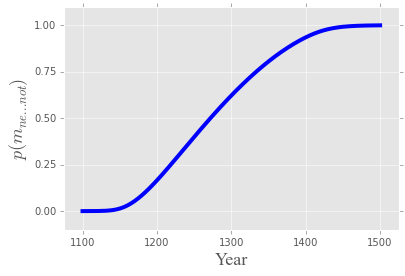

In [29]:
states = np.linspace(0,1, num=100)
timesteps=401

m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
years = [1100 + item for item in range(401)]

plt.plot(years, m2_sol, 'b', linewidth=4, zorder=3)
plt.ylim(-.1,1.1)
plt.xlim(1075, 1525)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 1, num=5))
plt.ylabel(r'$p(m_{ne...not})$', fontsize=18, **hfont)
plt.savefig("../local/out/p-ne-not.pdf", format='pdf', dpi=1000)
plt.show()

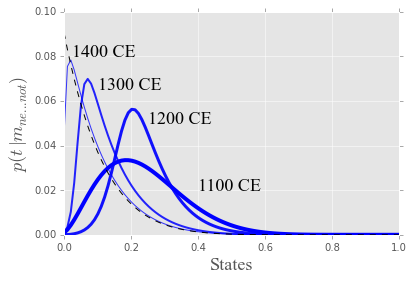

In [30]:
for j, i in enumerate(range(0,timesteps, timesteps/4)):
    p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
    p_m2 =  X_sol[i,1::2] * prior.T
    p_t_m2 = p_ti_m2 / p_m2
    plt.plot(states, p_t_m2.tolist()[0], color='b', linewidth=4-j, alpha=(1 - .3*(i/float(timesteps))))
# Label the curves at each century
plt.text(.4, .02, str(1100) + " CE", fontsize=18, **hfont)
plt.text(.25, .05, str(1200) + " CE", fontsize=18, **hfont)
plt.text(.1, .065, str(1300) + " CE", fontsize=18, **hfont)
plt.text(.025, .08, str(1400) + " CE", fontsize=18, **hfont)
plt.plot(states, prior.tolist()[0], 'k--')
plt.ylabel(r'$p(t \mid m_{ne...not})$', fontsize=18, **hfont)
plt.xlabel('States', fontsize=18, **hfont)
plt.savefig("../local/out/pt-ne-not.pdf", format='pdf', dpi=1000)
plt.show()

In [31]:
def calculate_KL(p_t_m, prior):
    KL = np.sum(np.multiply(np.log(np.divide(p_t_m, prior)), p_t_m))
    return KL

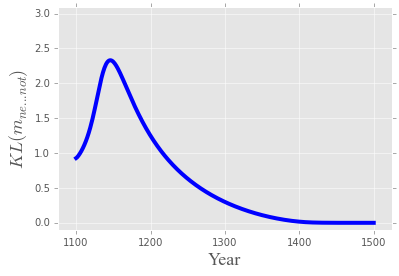

In [32]:
KL_t = []
for i in range(401):
    p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
    p_m2 =  X_sol[i,1::2] * prior.T
    p_t_m2 = p_ti_m2 / p_m2
    KL_t.append(calculate_KL(p_t_m2, prior))

    
years = [1100 + item for item in range(401)]
    
plt.plot(years, KL_t, 'b', linewidth=4)
plt.ylim(-.1, 3.1)
plt.xlim(1075, 1525)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 3, num=7))
plt.ylabel(r'$KL(m_{ne...not})$', fontsize=18, **hfont)
plt.savefig("../local/out/kl-plot.pdf", format='pdf', dpi=1000)
plt.show()

## Comparison with simplified model

We can assess whether positing a bias on the part of speakers is justified by comparing the full dynamic model to a simplified model where $b=0$ and $\alpha_s$ and $\beta_p$ are free to vary.

In [33]:
def simulate_simplified_dynamics(params, n_years=401, time_scale=1, number=100):
    """Simulate simplified dynamic model."""
    # Unpack the parameters
    a_s, b_p = params
    # Construct the initial state
    X0, Y0, A, B, prior = construct_initial_state(a_s, b_p)
    # Create prior probability matrix
    P = np.repeat(prior, 2, axis=0)
    # Iterate using dynamics to get values for the number of years
    X_sol, Y_sol = discrete_time_replicator_dynamics(n_years*time_scale, X0, Y0, A, B, P)
    X_sol = X_sol[0::time_scale,:]
    Y_sol = Y_sol[0::time_scale,:]
    return X_sol, Y_sol, prior

In [34]:
%%time
simplified_loss_function = partial(loss_function, func=simulate_simplified_dynamics)
rranges = (slice(1, 20, 1), slice(1, 20, 1))
simplified_results = brute(simplified_loss_function, rranges, finish=fmin)
print simplified_results

[ 50.37843169   0.06370185]
CPU times: user 1min 36s, sys: 735 ms, total: 1min 37s
Wall time: 49.6 s


We can compare the full and the simplified model using the difference in AIC.

In [ ]:
full_LL = -1 * loss_function(model_results)
simple_LL = -1*loss_function(simplified_results, func=simulate_simplified_dynamics)

full_AIC = 2*3 - 2*full_LL
simple_AIC = 2*2 - 2*simple_LL
delta_AIC =  simple_AIC - full_AIC
print delta_AIC

The probability that the simplified model is better than the full model is given by its Akaike weight.

In [ ]:
1 / (1 + np.exp(.5*delta_AIC))

To put this in perspective, this probability is roughly the magnitude of flipping a fair coin eight hundred times and it only ever coming up heads.

In [ ]:
.5**800

Since the full and simplified model are nested, we can also perform a Likelihood Ratio test, where the test statistic $D$ is $\chi^2$ distributed with one degree of freedom.  We reject the null hypothesis that the simplified model is correct.

In [ ]:
from scipy.stats import chi2
D = 2*(full_LL - simple_LL)
chi2_result = chi2.pdf(D,1)
print chi2_result